# 07 — Model Comparison and Final Recommendation  
Hotel Booking Demand (Cancellation Prediction)

## Notebook purpose
This notebook consolidates the outputs from individual model notebooks and provides:
- automated discovery of available artifacts (models and metrics)
- consistent evaluation on a single reproducible train/test split (when model pipelines are available)
- fallback comparison using saved metric JSON files when pipelines are missing
- report-ready comparison tables, plots, and a final model recommendation
- a clear missing-artifacts report if expected files are not present or not in the expected structure

## Expected inputs (artifacts)
Models (preferred for consistent evaluation):
- `artifacts/models/logreg_pipeline.joblib`
- `artifacts/models/knn_pipeline.joblib`
- `artifacts/models/dt_pipeline.joblib`
- `artifacts/models/rf_pipeline.joblib`

Saved metrics (fallback comparison):
- `artifacts/metrics/logreg_test_metrics.json`
- `artifacts/metrics/knn_test_metrics.json`
- `artifacts/metrics/dt_test_metrics.json`
- `artifacts/metrics/rf_test_metrics.json`

## Outputs (overwritten on each run)
- `artifacts/metrics/model_comparison.csv`
- `artifacts/metrics/model_ranking.json`
- `artifacts/metrics/final_recommendation.json`
- `artifacts/reports/missing_artifacts_report.md`
- `artifacts/reports/model_comparison_notes.md`
- Plots under `artifacts/plots/`:
  - `compare_f1_bar.png`
  - `compare_precision_recall_bar.png`
  - `compare_balanced_accuracy_bar.png`
  - `compare_roc_overlay.png` (only if probability outputs are available)
  - `compare_pr_overlay.png` (only if probability outputs are available)

The notebook overwrites outputs to keep the latest results available for the final submission.


In [1]:
# Repository bootstrap (fixes ModuleNotFoundError: 'src')
# The repository root is resolved quickly using Git when available.
# A bounded parent-directory scan is used as a fallback.

import os
import sys
import subprocess
from pathlib import Path

def _find_repo_root(max_levels: int = 25) -> Path:
    try:
        out = subprocess.check_output(
            ["git", "rev-parse", "--show-toplevel"],
            stderr=subprocess.DEVNULL,
            text=True,
        ).strip()
        p = Path(out)
        if (p / "src").is_dir():
            return p
    except Exception:
        pass

    cwd = Path.cwd()
    for p in [cwd] + list(cwd.parents)[:max_levels]:
        if (p / "src").is_dir():
            return p

    raise FileNotFoundError(
        "Folder 'src' was not found within the parent directories. "
        "Open the repository root folder in VS Code and rerun the notebook."
    )

root = _find_repo_root(max_levels=25)
os.chdir(root)
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

print("Working directory:", Path.cwd())
print("Python path entry added:", root)


Working directory: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment
Python path entry added: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment


## Imports, configuration, and artifact folders

Configuration values are loaded with safe fallbacks to avoid notebook failure when optional constants are missing.


In [2]:
import json
import platform
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    log_loss,
    roc_curve,
    precision_recall_curve,
    confusion_matrix,
)

try:
    from tqdm.auto import tqdm
except Exception:
    raise ImportError("Package 'tqdm' is required. Install with: pip install tqdm")

# joblib is used for loading saved sklearn pipelines
try:
    import joblib
except Exception:
    raise ImportError("Package 'joblib' is required. Install with: pip install joblib")

# Artifact helpers (fallback provided if src.io_utils is not available)
try:
    from src.io_utils import ensure_artifact_dirs, save_json, save_text, save_dataframe, save_run_metadata
except Exception:
    def ensure_artifact_dirs(base_dir="artifacts"):
        base = Path(base_dir)
        paths = {
            "base": base,
            "data": base / "data",
            "preprocessing": base / "preprocessing",
            "models": base / "models",
            "metrics": base / "metrics",
            "plots": base / "plots",
            "reports": base / "reports",
        }
        for p in paths.values():
            p.mkdir(parents=True, exist_ok=True)
        return paths

    def save_json(obj, path):
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w", encoding="utf-8") as f:
            json.dump(obj, f, indent=2)

    def save_text(text, path):
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        Path(path).write_text(text, encoding="utf-8")

    def save_dataframe(df, path, index=False):
        Path(path).parent.mkdir(parents=True, exist_ok=True)
        df.to_csv(path, index=index)

    def save_run_metadata(meta, base_dir="artifacts", repo_root="."):
        out = Path(base_dir) / "reports" / "run_metadata.json"
        save_json(meta, out)
        return out

# Safe config loading
import src.config as cfg
PROJECT_NAME = getattr(cfg, "PROJECT_NAME", "ML-assignment")
RANDOM_STATE = int(getattr(cfg, "RANDOM_STATE", 42))
TARGET_COL = getattr(cfg, "TARGET_COL", "is_canceled")
TEST_SIZE = float(getattr(cfg, "TEST_SIZE", 0.20))
DEFAULT_DATA_PATH = str(getattr(cfg, "DEFAULT_DATA_PATH", "data/raw/hotel_bookings.csv"))
HIGH_CARDINALITY_COLS = list(getattr(cfg, "HIGH_CARDINALITY_COLS", ["agent", "company"]))

ART = ensure_artifact_dirs("artifacts")

meta_path = save_run_metadata(
    {
        "project": PROJECT_NAME,
        "random_state": RANDOM_STATE,
        "test_size": TEST_SIZE,
        "target_col": TARGET_COL,
        "notebook": "07_model_comparison.ipynb",
        "python_version": sys.version,
        "platform": platform.platform(),
    },
    base_dir="artifacts",
    repo_root=".",
)
print("Metadata file:", meta_path.resolve())
print("Artifacts base:", ART["base"].resolve())

display(pd.DataFrame([{
    "PROJECT_NAME": PROJECT_NAME,
    "RANDOM_STATE": RANDOM_STATE,
    "TEST_SIZE": TEST_SIZE,
    "TARGET_COL": TARGET_COL,
    "HIGH_CARDINALITY_COLS": ", ".join(HIGH_CARDINALITY_COLS),
}]))


Metadata file: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\run_metadata.json
Artifacts base: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts


d:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,PROJECT_NAME,RANDOM_STATE,TEST_SIZE,TARGET_COL,HIGH_CARDINALITY_COLS
0,ML-assignment,42,0.2,is_canceled,"agent, company"


## Artifact discovery and validation

This section:
- checks the expected artifact paths
- searches for misplaced files under `artifacts/` (helpful when a notebook saved to a different subfolder)
- produces a missing-artifacts report with actionable guidance


In [3]:
from collections import defaultdict

expected = {
    "logreg": {
        "pipeline": ART["models"] / "logreg_pipeline.joblib",
        "metrics": ART["metrics"] / "logreg_test_metrics.json",
        "best_params": ART["metrics"] / "logreg_best_params.json",
        "cv_results": ART["metrics"] / "logreg_cv_results.csv",
    },
    "knn": {
        "pipeline": ART["models"] / "knn_pipeline.joblib",
        "metrics": ART["metrics"] / "knn_test_metrics.json",
        "best_params": ART["metrics"] / "knn_best_params.json",
        "cv_results": ART["metrics"] / "knn_cv_results.csv",
    },
    "dt": {
        "pipeline": ART["models"] / "dt_pipeline.joblib",
        "metrics": ART["metrics"] / "dt_test_metrics.json",
        "best_params": ART["metrics"] / "dt_best_params.json",
        "cv_results": ART["metrics"] / "dt_cv_results.csv",
    },
    "rf": {
        "pipeline": ART["models"] / "rf_pipeline.joblib",
        "metrics": ART["metrics"] / "rf_test_metrics.json",
        "best_params": ART["metrics"] / "rf_best_params.json",
        "cv_results": ART["metrics"] / "rf_cv_results.csv",
    },
}

def file_exists(p: Path) -> bool:
    try:
        return p.exists()
    except Exception:
        return False

rows = []
for model, d in expected.items():
    for kind, path in d.items():
        rows.append({"model": model, "artifact": kind, "expected_path": str(path), "exists": file_exists(path)})

expected_status = pd.DataFrame(rows)
display(expected_status)

# Search for misplaced files (limited patterns)
artifact_root = ART["base"]
found = defaultdict(list)

patterns = [
    ("test_metrics.json", "*test_metrics.json"),
    ("pipeline.joblib", "*pipeline*.joblib"),
    ("best_params.json", "*best_params.json"),
    ("cv_results.csv", "*cv_results.csv"),
]

for label, pattern in patterns:
    for p in artifact_root.rglob(pattern):
        found[label].append(str(p))

found_df_rows = []
for label, paths in found.items():
    for p in paths[:50]:  # cap display
        found_df_rows.append({"pattern_group": label, "found_path": p})
found_df = pd.DataFrame(found_df_rows)

if len(found_df) > 0:
    display(found_df)
else:
    print("No matching artifacts discovered under artifacts/.")

# Missing report
missing_lines = []
missing_lines.append("# Missing artifacts report")
missing_lines.append("")
missing_lines.append("## Expected paths that are missing")
missing_any = False
for _, r in expected_status.iterrows():
    if not bool(r["exists"]):
        missing_any = True
        missing_lines.append(f"- Missing: `{r['expected_path']}`")

if not missing_any:
    missing_lines.append("- All expected artifacts were found.")
else:
    missing_lines.append("")
    missing_lines.append("## Files found under artifacts/ (possible misplacements)")
    if len(found_df) == 0:
        missing_lines.append("- No candidate files were found under `artifacts/`.")
    else:
        for label, paths in found.items():
            if paths:
                missing_lines.append(f"- {label}:")
                for p in paths[:20]:
                    missing_lines.append(f"  - `{p}`")

missing_report_path = ART["reports"] / "missing_artifacts_report.md"
save_text("\n".join(missing_lines), missing_report_path)
print("Saved:", missing_report_path.resolve())


,model,artifact,expected_path,exists
0,logreg,pipeline,artifacts\models\logreg_pipeline.joblib,True
1,logreg,metrics,artifacts\metrics\logreg_test_metrics.json,True
2,logreg,best_params,artifacts\metrics\logreg_best_params.json,True
3,logreg,cv_results,artifacts\metrics\logreg_cv_results.csv,True
4,knn,pipeline,artifacts\models\knn_pipeline.joblib,False
5,knn,metrics,artifacts\metrics\knn_test_metrics.json,False
6,knn,best_params,artifacts\metrics\knn_best_params.json,False
7,knn,cv_results,artifacts\metrics\knn_cv_results.csv,False
8,dt,pipeline,artifacts\models\dt_pipeline.joblib,True
9,dt,metrics,artifacts\metrics\dt_test_metrics.json,True


,pattern_group,found_path
0,test_metrics.json,artifacts\metrics\dt_test_metrics.json
1,test_metrics.json,artifacts\metrics\logreg_test_metrics.json
2,pipeline.joblib,artifacts\models\dt_pipeline.joblib
3,pipeline.joblib,artifacts\models\logreg_pipeline.joblib
4,best_params.json,artifacts\metrics\dt_best_params.json
5,best_params.json,artifacts\metrics\logreg_best_params.json
6,cv_results.csv,artifacts\metrics\dt_cv_results.csv
7,cv_results.csv,artifacts\metrics\logreg_cv_results.csv


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\missing_artifacts_report.md


## Dataset loading and reproducible split

A single deterministic stratified split is created to support fair comparison when model pipelines are available.
If a pipeline is missing, saved metric JSON results are used as a fallback.


In [4]:
# Load dataset using the shared loader when available; fallback to pandas otherwise
preferred_processed = Path("data/processed/hotel_bookings_dedup.csv")
preferred_raw = Path(DEFAULT_DATA_PATH)
dataset_path = preferred_processed if preferred_processed.exists() else preferred_raw

if not dataset_path.exists():
    raise FileNotFoundError("Dataset not found. Expected at data/raw/hotel_bookings.csv or data/processed/hotel_bookings_dedup.csv")

print("Dataset path:", dataset_path.resolve())

try:
    from src.data_loader import load_hotel_bookings, basic_train_ready_checks
    df = load_hotel_bookings(dataset_path, drop_duplicates=False, verbose=True)
    basic_train_ready_checks(df, target_col=TARGET_COL)
except Exception:
    df = pd.read_csv(dataset_path)
    if TARGET_COL not in df.columns:
        raise ValueError(f"Target column not found: {TARGET_COL}")

# Type safety for ID-like columns (matches earlier notebooks; leakage-safe)
df_model = df.copy()
for c in HIGH_CARDINALITY_COLS:
    if c in df_model.columns:
        df_model[c] = pd.to_numeric(df_model[c], errors="coerce").astype("Int64").astype("string")
        df_model[c] = df_model[c].fillna("MISSING")

X = df_model.drop(columns=[TARGET_COL])
y = df_model[TARGET_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y,
)

split_info = {
    "n_rows_total": int(len(df_model)),
    "n_train": int(len(X_train)),
    "n_test": int(len(X_test)),
    "test_size": float(TEST_SIZE),
    "random_state": int(RANDOM_STATE),
    "stratified": True,
}
save_json(split_info, ART["data"] / "train_test_split_comparison.json")
print("Saved:", (ART["data"] / "train_test_split_comparison.json").resolve())

display(pd.DataFrame([split_info]))

dist = y_test.value_counts().rename_axis("label").reset_index(name="count")
dist["rate"] = dist["count"] / dist["count"].sum()
display(dist)


Dataset path: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\data\processed\hotel_bookings_dedup.csv
[data_loader] Loaded shape: (87396, 32)
[data_loader] Columns: 32
Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\data\train_test_split_comparison.json


,n_rows_total,n_train,n_test,test_size,random_state,stratified
0,87396,69916,17480,0.2,42,True


,label,count,rate
0,0,12675,0.725114
1,1,4805,0.274886


## Evaluation helpers

A consistent metric schema is used across models.
Probability-based metrics are computed only when `predict_proba` is available.


In [5]:
def compute_metrics(y_true, y_pred, y_proba=None) -> dict:
    cm = confusion_matrix(y_true, y_pred)
    out = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "balanced_accuracy": float(balanced_accuracy_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred, zero_division=0)),
        "recall": float(recall_score(y_true, y_pred, zero_division=0)),
        "f1": float(f1_score(y_true, y_pred, zero_division=0)),
        "confusion_matrix": cm.tolist(),
    }
    if y_proba is not None:
        # Guard against edge cases where one class is missing in the test set
        try:
            out["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            out["roc_auc"] = None
        try:
            out["pr_auc"] = float(average_precision_score(y_true, y_proba))
        except Exception:
            out["pr_auc"] = None
        try:
            out["log_loss"] = float(log_loss(y_true, y_proba, labels=[0, 1]))
        except Exception:
            out["log_loss"] = None
    else:
        out["roc_auc"] = None
        out["pr_auc"] = None
        out["log_loss"] = None
    return out

def load_json_if_exists(path: Path):
    if path.exists():
        return json.loads(path.read_text(encoding="utf-8"))
    return None

def safe_joblib_load(path: Path):
    try:
        return joblib.load(path)
    except Exception as e:
        return None, str(e)


## Load pipelines and/or metrics, then build the comparison table

Preferred approach:
- load each saved pipeline and evaluate on the same `X_test`, `y_test` split

Fallback approach:
- if a pipeline is missing or fails to load, use the saved `*_test_metrics.json`


In [6]:
models_order = ["logreg", "knn", "dt", "rf"]

results = []
curves = {}  # store ROC/PR curve data when probabilities exist
errors = []

for model_key in tqdm(models_order, desc="Evaluating available models"):
    paths = expected[model_key]
    pipe_path = paths["pipeline"]
    metrics_path = paths["metrics"]

    entry = {"model": model_key, "source": None}
    y_proba = None

    if pipe_path.exists():
        obj = None
        err = None
        try:
            obj = joblib.load(pipe_path)
        except Exception as e:
            err = str(e)

        if obj is not None:
            # Evaluate pipeline on consistent test split
            y_pred = obj.predict(X_test)
            if hasattr(obj, "predict_proba"):
                try:
                    y_proba = obj.predict_proba(X_test)[:, 1]
                except Exception:
                    y_proba = None

            m = compute_metrics(y_test, y_pred, y_proba=y_proba)
            entry.update(m)
            entry["source"] = "pipeline_eval"
        else:
            errors.append({"model": model_key, "pipeline_path": str(pipe_path), "error": err})
    else:
        errors.append({"model": model_key, "pipeline_path": str(pipe_path), "error": "pipeline_not_found"})

    # Fallback to saved metrics JSON if pipeline evaluation is not available
    if entry.get("source") is None:
        saved = load_json_if_exists(metrics_path)
        if saved is not None:
            # Normalize expected keys
            entry.update({
                "accuracy": saved.get("accuracy"),
                "balanced_accuracy": saved.get("balanced_accuracy"),
                "precision": saved.get("precision"),
                "recall": saved.get("recall"),
                "f1": saved.get("f1"),
                "roc_auc": saved.get("roc_auc"),
                "pr_auc": saved.get("pr_auc"),
                "log_loss": saved.get("log_loss"),
                "confusion_matrix": saved.get("confusion_matrix"),
            })
            entry["source"] = "saved_metrics_json"
        else:
            entry["source"] = "missing"

    # Curves are recorded only when probabilities exist from pipeline evaluation
    if entry.get("source") == "pipeline_eval" and y_proba is not None:
        try:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            prec, rec, _ = precision_recall_curve(y_test, y_proba)
            curves[model_key] = {
                "roc": {"fpr": fpr, "tpr": tpr},
                "pr": {"precision": prec, "recall": rec},
            }
        except Exception:
            pass

    results.append(entry)

comparison_df = pd.DataFrame(results)

# Model name formatting for the report
name_map = {"logreg": "Logistic Regression", "knn": "KNN", "dt": "Decision Tree", "rf": "Random Forest"}
comparison_df["model_name"] = comparison_df["model"].map(name_map).fillna(comparison_df["model"])

# Order columns for readability
cols = ["model", "model_name", "source", "f1", "precision", "recall", "balanced_accuracy", "accuracy", "roc_auc", "pr_auc", "log_loss", "confusion_matrix"]
comparison_df = comparison_df[cols]

display(comparison_df)

out_csv = ART["metrics"] / "model_comparison.csv"
save_dataframe(comparison_df, out_csv, index=False)
print("Saved:", out_csv.resolve())

if errors:
    display(pd.DataFrame(errors))


Evaluating available models: 100%|██████████| 4/4 [00:00<00:00,  6.74it/s]


,model,model_name,source,f1,precision,recall,balanced_accuracy,accuracy,roc_auc,pr_auc,log_loss,confusion_matrix
0,logreg,Logistic Regression,pipeline_eval,0.668509,0.559260,0.830801,0.791298,0.773513,0.865841,0.693289,0.461625,"[[9529, 3146], [813, 3992]]"
1,knn,KNN,missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,dt,Decision Tree,pipeline_eval,0.684161,0.584513,0.824766,0.801259,0.790675,0.875145,0.728146,1.036469,"[[9858, 2817], [842, 3963]]"
3,rf,Random Forest,missing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\metrics\model_comparison.csv


,model,pipeline_path,error
0,knn,artifacts\models\knn_pipeline.joblib,pipeline_not_found
1,rf,artifacts\models\rf_pipeline.joblib,pipeline_not_found


## Ranking and final recommendation

Ranking uses the primary metric **F1** by default (aligned with the project approach).
If F1 is missing for a model, that model is excluded from the ranking.


In [7]:
rank_metric = "f1"

rankable = comparison_df.dropna(subset=[rank_metric]).copy()
rankable[rank_metric] = pd.to_numeric(rankable[rank_metric], errors="coerce")
rankable = rankable.dropna(subset=[rank_metric])

if len(rankable) == 0:
    print("No models have a valid F1 score. Check missing-artifacts report.")
    ranking = []
    recommendation = {"status": "no_valid_models", "rank_metric": rank_metric}
else:
    rankable = rankable.sort_values(rank_metric, ascending=False).reset_index(drop=True)
    ranking = rankable[["model", "model_name", "source", rank_metric, "precision", "recall", "balanced_accuracy", "roc_auc", "pr_auc", "log_loss"]].to_dict(orient="records")

    best = ranking[0]
    recommendation = {
        "status": "ok",
        "rank_metric": rank_metric,
        "best_model_key": best["model"],
        "best_model_name": best["model_name"],
        "best_model_source": best["source"],
        "best_f1": best.get("f1"),
        "supporting_metrics": {
            "precision": best.get("precision"),
            "recall": best.get("recall"),
            "balanced_accuracy": best.get("balanced_accuracy"),
            "roc_auc": best.get("roc_auc"),
            "pr_auc": best.get("pr_auc"),
            "log_loss": best.get("log_loss"),
        },
        "notes": [
            "The selected model has the highest available F1 score under the comparison procedure.",
            "Probability-based metrics are included only when available from pipeline evaluation or saved metrics.",
        ],
    }

save_json(ranking, ART["metrics"] / "model_ranking.json")
save_json(recommendation, ART["metrics"] / "final_recommendation.json")

print("Saved:", (ART["metrics"] / "model_ranking.json").resolve())
print("Saved:", (ART["metrics"] / "final_recommendation.json").resolve())

display(pd.DataFrame(ranking[:10]))
display(pd.DataFrame([recommendation]))


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\metrics\model_ranking.json
Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\metrics\final_recommendation.json


,model,model_name,source,f1,precision,recall,balanced_accuracy,roc_auc,pr_auc,log_loss
0,dt,Decision Tree,pipeline_eval,0.684161,0.584513,0.824766,0.801259,0.875145,0.728146,1.036469
1,logreg,Logistic Regression,pipeline_eval,0.668509,0.559260,0.830801,0.791298,0.865841,0.693289,0.461625


,status,rank_metric,best_model_key,best_model_name,best_model_source,best_f1,supporting_metrics,notes
0,ok,f1,dt,Decision Tree,pipeline_eval,0.684161,"{'precision': 0.5845132743362832, 'recall': 0....",[The selected model has the highest available ...


## Comparison plots (report-ready)

Plots are displayed inline and saved under `artifacts/plots/`.


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\compare_f1_bar.png


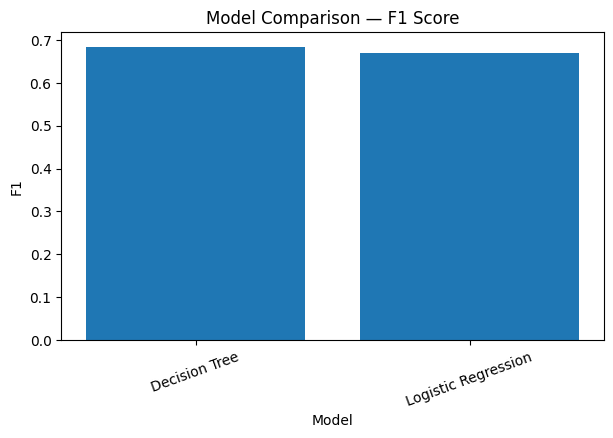

In [8]:
# F1 comparison (bar)
plot_df = comparison_df.dropna(subset=["f1"]).copy()
plot_df["f1"] = pd.to_numeric(plot_df["f1"], errors="coerce")
plot_df = plot_df.dropna(subset=["f1"]).sort_values("f1", ascending=False)

if len(plot_df) == 0:
    print("F1 plot skipped: no valid F1 values.")
else:
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(plot_df["model_name"], plot_df["f1"])
    ax.set_title("Model Comparison — F1 Score")
    ax.set_xlabel("Model")
    ax.set_ylabel("F1")
    ax.tick_params(axis="x", rotation=20)

    out = ART["plots"] / "compare_f1_bar.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved:", out.resolve())

    plt.show()
    plt.close(fig)


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\compare_precision_recall_bar.png


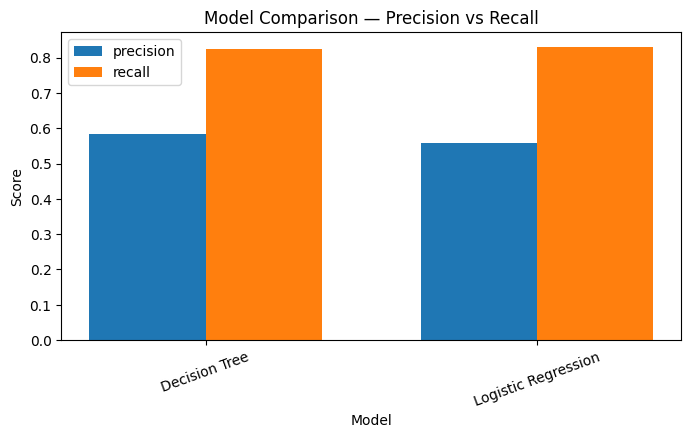

In [9]:
# Precision/Recall comparison (two bars per model, single figure)
plot_df = comparison_df.dropna(subset=["precision", "recall"]).copy()
plot_df["precision"] = pd.to_numeric(plot_df["precision"], errors="coerce")
plot_df["recall"] = pd.to_numeric(plot_df["recall"], errors="coerce")
plot_df = plot_df.dropna(subset=["precision", "recall"]).sort_values("f1", ascending=False)

if len(plot_df) == 0:
    print("Precision/Recall plot skipped: missing values.")
else:
    x = np.arange(len(plot_df))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 4))
    ax.bar(x - width/2, plot_df["precision"], width, label="precision")
    ax.bar(x + width/2, plot_df["recall"], width, label="recall")
    ax.set_title("Model Comparison — Precision vs Recall")
    ax.set_xlabel("Model")
    ax.set_ylabel("Score")
    ax.set_xticks(x)
    ax.set_xticklabels(plot_df["model_name"], rotation=20)
    ax.legend()

    out = ART["plots"] / "compare_precision_recall_bar.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved:", out.resolve())

    plt.show()
    plt.close(fig)


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\compare_balanced_accuracy_bar.png


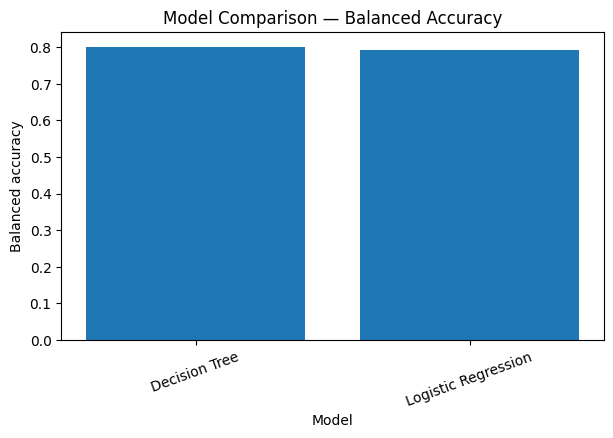

In [10]:
# Balanced accuracy comparison (bar)
plot_df = comparison_df.dropna(subset=["balanced_accuracy"]).copy()
plot_df["balanced_accuracy"] = pd.to_numeric(plot_df["balanced_accuracy"], errors="coerce")
plot_df = plot_df.dropna(subset=["balanced_accuracy"]).sort_values("balanced_accuracy", ascending=False)

if len(plot_df) == 0:
    print("Balanced accuracy plot skipped: missing values.")
else:
    fig, ax = plt.subplots(figsize=(7, 4))
    ax.bar(plot_df["model_name"], plot_df["balanced_accuracy"])
    ax.set_title("Model Comparison — Balanced Accuracy")
    ax.set_xlabel("Model")
    ax.set_ylabel("Balanced accuracy")
    ax.tick_params(axis="x", rotation=20)

    out = ART["plots"] / "compare_balanced_accuracy_bar.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved:", out.resolve())

    plt.show()
    plt.close(fig)


## ROC / PR overlay plots (only when probabilities are available)

Overlay plots are produced only when at least one model provides probabilities from a loaded pipeline.


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\compare_roc_overlay.png


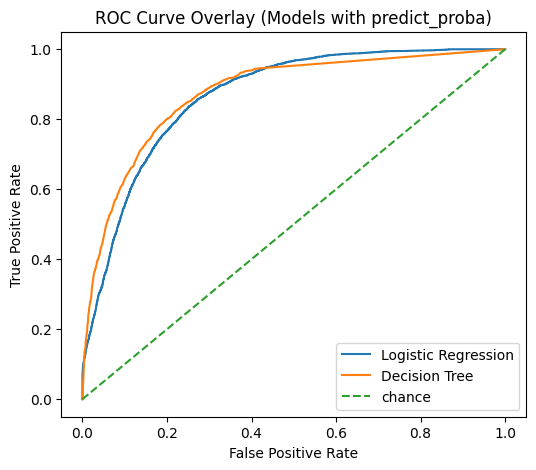

In [11]:
# ROC overlay
if len(curves) == 0:
    print("ROC overlay skipped: no probability outputs were available from pipelines.")
else:
    fig, ax = plt.subplots(figsize=(6, 5))
    for k, data in curves.items():
        ax.plot(data["roc"]["fpr"], data["roc"]["tpr"], label=name_map.get(k, k))
    ax.plot([0, 1], [0, 1], linestyle="--", label="chance")
    ax.set_title("ROC Curve Overlay (Models with predict_proba)")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend()

    out = ART["plots"] / "compare_roc_overlay.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved:", out.resolve())

    plt.show()
    plt.close(fig)


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\plots\compare_pr_overlay.png


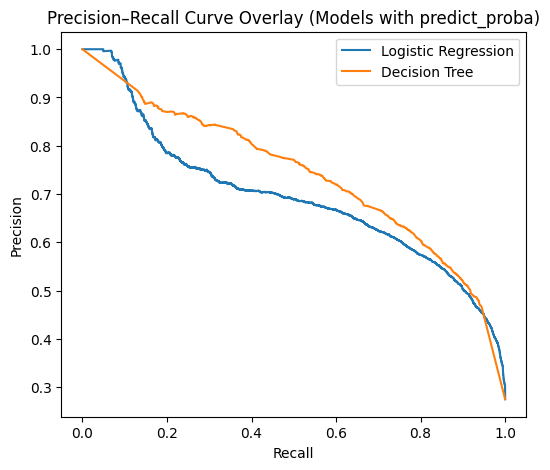

In [12]:
# PR overlay
if len(curves) == 0:
    print("PR overlay skipped: no probability outputs were available from pipelines.")
else:
    fig, ax = plt.subplots(figsize=(6, 5))
    for k, data in curves.items():
        ax.plot(data["pr"]["recall"], data["pr"]["precision"], label=name_map.get(k, k))
    ax.set_title("Precision–Recall Curve Overlay (Models with predict_proba)")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()

    out = ART["plots"] / "compare_pr_overlay.png"
    fig.savefig(out, dpi=150, bbox_inches="tight")
    print("Saved:", out.resolve())

    plt.show()
    plt.close(fig)


## Critical analysis and discussion (report-ready)

This section provides structured content aligned with the marking rubric:
- results summary and model choice justification
- limitations observed in the experiments
- improvement ideas and future work


In [13]:
# Generate a concise discussion based on the comparison table
lines = []
lines.append("# Model comparison discussion")
lines.append("")
lines.append("## Results summary")
if len(rankable) == 0:
    lines.append("- No valid ranking could be produced because F1 scores were unavailable.")
else:
    best_name = recommendation.get("best_model_name")
    best_f1 = recommendation.get("best_f1")
    lines.append(f"- The highest available F1 score is achieved by **{best_name}** (F1 = {best_f1}).")
    lines.append("- Additional metrics (precision, recall, balanced accuracy, ROC-AUC, PR-AUC, log loss) support the final selection where available.")
lines.append("")
lines.append("## Observations")
lines.append("- F1 is used as the primary ranking metric because it balances precision and recall under class imbalance.")
lines.append("- Probability-based metrics (ROC-AUC, PR-AUC, log loss) are included only when probability outputs are available.")
lines.append("")
lines.append("## Limitations")
lines.append("- Some models may be missing or evaluated from saved metrics only, which may reflect different splits if pipelines are not available.")
lines.append("- Feature engineering is limited to simple derived variables and one-hot encoding; interaction effects may not be fully captured by linear models.")
lines.append("- High-cardinality categoricals can increase dimensionality and may require alternative encodings or category grouping for additional stability.")
lines.append("")
lines.append("## Improvements and future work")
lines.append("- Add probability calibration (e.g., Platt scaling or isotonic calibration) and evaluate calibration curves.")
lines.append("- Use a consistent saved split index file (train/test indices) to ensure identical evaluation across notebooks and environments.")
lines.append("- Expand hyperparameter search using randomized search with time/compute budgets and cross-validated reporting.")
lines.append("- Investigate feature grouping for rare categories and perform ablation studies to measure feature engineering impact.")
lines.append("- Evaluate robustness across multiple random seeds and report confidence intervals for key metrics.")
lines.append("")

notes_path = ART["reports"] / "model_comparison_notes.md"
save_text("\n".join(lines), notes_path)
print("Saved:", notes_path.resolve())

print("\n".join(lines[:30]))


Saved: D:\Documents\SLIIT_Campus\Y4S2\ML_IT4060\ML_assignment_01\Machine-Learning-Assignment\artifacts\reports\model_comparison_notes.md
# Model comparison discussion

## Results summary
- The highest available F1 score is achieved by **Decision Tree** (F1 = 0.684160552438498).
- Additional metrics (precision, recall, balanced accuracy, ROC-AUC, PR-AUC, log loss) support the final selection where available.

## Observations
- F1 is used as the primary ranking metric because it balances precision and recall under class imbalance.
- Probability-based metrics (ROC-AUC, PR-AUC, log loss) are included only when probability outputs are available.

## Limitations
- Some models may be missing or evaluated from saved metrics only, which may reflect different splits if pipelines are not available.
- Feature engineering is limited to simple derived variables and one-hot encoding; interaction effects may not be fully captured by linear models.
- High-cardinality categoricals can increase dimension

## Expected artifact checklist

This table confirms the presence of the primary outputs produced by this notebook.


In [14]:
expected_outputs = [
    ART["metrics"] / "model_comparison.csv",
    ART["metrics"] / "model_ranking.json",
    ART["metrics"] / "final_recommendation.json",
    ART["reports"] / "missing_artifacts_report.md",
    ART["reports"] / "model_comparison_notes.md",
    ART["plots"] / "compare_f1_bar.png",
    ART["plots"] / "compare_precision_recall_bar.png",
    ART["plots"] / "compare_balanced_accuracy_bar.png",
    ART["plots"] / "compare_roc_overlay.png",
    ART["plots"] / "compare_pr_overlay.png",
]

display(pd.DataFrame([{"path": str(p), "exists": p.exists()} for p in expected_outputs]))


,path,exists
0,artifacts\metrics\model_comparison.csv,True
1,artifacts\metrics\model_ranking.json,True
2,artifacts\metrics\final_recommendation.json,True
3,artifacts\reports\missing_artifacts_report.md,True
4,artifacts\reports\model_comparison_notes.md,True
5,artifacts\plots\compare_f1_bar.png,True
6,artifacts\plots\compare_precision_recall_bar.png,True
7,artifacts\plots\compare_balanced_accuracy_bar.png,True
8,artifacts\plots\compare_roc_overlay.png,True
9,artifacts\plots\compare_pr_overlay.png,True
